
## Implementación de un Codificador Automático Variacional (VAE)

El **Codificador Automático Variacional** (VAE, por sus siglas en inglés) es un modelo generativo basado en redes neuronales profundas. Su objetivo es aprender una representación comprimida (espacio latente) de los datos de entrada, permitiendo tanto la reconstrucción como la generación de nuevos datos similares.

El VAE difiere de un autoencoder clásico en que, en lugar de codificar los datos a un vector determinista, se aprende una **distribución probabilística** (media y varianza) sobre el espacio latente. Esto permite una mejor generalización y permite muestrear nuevos datos.

Este cuaderno implementa un VAE para imágenes del conjunto de datos MNIST (dígitos escritos a mano), usando capas convolucionales para la codificación y decodificación.

Las principales partes del VAE son:

- El **codificador** que mapea imágenes a un espacio latente distribuido normal multivariado.
- El **muestreo reparametrizado** del vector latente.
- El **decodificador** que reconstruye la imagen desde el vector latente.
- La **función de costo**, que combina el error de reconstrucción (entropía cruzada) y la divergencia Kullback-Leibler (KL) entre la distribución latente aprendida y una distribución normal estándar.


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Modelo del Codificador automático variacional (VAE)

Completa la función `vae` para definir la arquitectura del modelo con base en las siguientes características:

### Arquitectura del modelo:

**Codificador (Encoder)**

1. Capa de entrada: acepta imágenes de forma (28, 28, 1)
2. Tres bloques convolucionales secuenciales:
   - Convolución 2D (64 filtros, kernel 4x4, stride 2x2)
   - Normalización por lotes (BatchNormalization)
   - Activación LeakyReLU (α=0.3)
3. Aplanamiento de características
4. Capas densas para μ y log σ² (n_hidden neuronas cada una)
5. Muestreo estocástico mediante truco de reparametrización

**Decodificador (Decoder)**

1. Capas densas de expansión (32 y 64 neuronas)
2. Reconfiguración a tensor 3D (8, 8, 1)
3. Tres capas de convolución transpuesta:
   - Primera: 64 filtros, kernel 4x4, stride 2x2 (upsampling)
   - Segunda y tercera: 64 filtros, kernel 4x4, stride 1x1
4. Aplanamiento y capa densa final (784 neuronas)
5. Activación sigmoide y reconfiguración a (28, 28, 1)

In [9]:
def vae(n_hidden = 8):

    """
    Construye y retorna un modelo de Autocodificador Variacional (VAE) para
    generación y reconstrucción de imágenes utilizando TensorFlow/Keras.

    Esta función implementa una arquitectura completa de VAE que combina un
    codificador convolucional con un decodificador transpuesto convolucional,
    diseñada específicamente para procesar imágenes en escala de grises de
    28x28 píxeles. El modelo emplea el truco de reparametrización para permitir
    el entrenamiento mediante retropropagación en el espacio latente estocástico.

    Parámetros:
    -----------
    n_hidden : int, opcional (default=8)
        Dimensionalidad del espacio latente (espacio de representación comprimida).
        Define el número de variables latentes que codifican la representación
        probabilística de los datos de entrada.

    Retorna:
    --------
    tf.keras.Model
        Modelo de Keras con múltiples salidas:
        - Salida principal: imagen reconstruida de forma (28, 28, 1)
        - Media (μ): vector de medias del espacio latente
        - Log-varianza (log σ²): vector de log-varianzas del espacio latente
    """

    input_layer = tf.keras.Input((28,28,1), name='input_layer')
    input_labels = tf.keras.Input((10,), name = 'input_labels')

    # Codificador convolucional
    xlabels = tf.keras.layers.Dense(28*28*10)(input_labels)
    xlabels = tf.keras.layers.Reshape((28,28,10))(xlabels)

    xenc = tf.keras.layers.Concatenate()([input_layer, xlabels])
    for n in range(3):
        xenc = tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides=(2,2))(xenc)
        xenc = tf.keras.layers.BatchNormalization()(xenc)
        xenc = tf.keras.layers.LeakyReLU(0.3)(xenc)

    # Capas de codificación a espacio latente
    xenc = tf.keras.layers.Flatten()(xenc)
    mean_layer = tf.keras.layers.Dense(n_hidden)(xenc)
    log_var_layer = tf.keras.layers.Dense(n_hidden)(xenc)

    # Truco de reparametrización - CORRECCIÓN AQUÍ
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, name='z_vector')([mean_layer, log_var_layer])
    z = tf.keras.layers.Concatenate()([z, input_labels])

    # Decodificador
    xdec = tf.keras.layers.Dense(32)(z)
    xdec = tf.keras.layers.LeakyReLU(0.3)(xdec)

    xdec = tf.keras.layers.Dense(64)(xdec)
    xdec = tf.keras.layers.LeakyReLU(0.3)(xdec)
    xdec = tf.keras.layers.Reshape((8,8,1))(xdec)

    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                           strides=(2,2), padding='same', activation='relu')(xdec)
    xdec =  tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                            strides=(1,1), padding='same', activation='relu')(xdec)
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                           strides=(1,1), padding='same', activation='relu')(xdec)

    xdec = tf.keras.layers.Flatten()(xdec)
    xdec = tf.keras.layers.Dense(28*28)(xdec)
    xdec = tf.keras.layers.Activation('sigmoid')(xdec)
    xout = tf.keras.layers.Reshape((28,28,1), name='output_layer')(xdec)

    vae_model = tf.keras.Model(inputs = [input_layer, input_labels],
                               outputs = [xout, mean_layer, log_var_layer], name='vae')

    return vae_model

### 2. Funciones auxiliares

In [3]:
def data_load():

    """
    Carga y preprocesa el conjunto de datos MNIST para entrenamiento de modelos
    de aprendizaje profundo.

    Esta función utilitaria descarga automáticamente el dataset MNIST desde los
    repositorios de Keras, realiza el preprocesamiento estándar incluyendo
    normalización de píxeles y expansión dimensional para compatibilidad con
    arquitecturas convolucionales que requieren canales explícitos.

    Retorna:
    --------
    tuple
        Tupla de cuatro elementos conteniendo los conjuntos de datos procesados:

        train_x : np.ndarray
            Imágenes de entrenamiento normalizadas.
            Forma: (60000, 28, 28, 1), dtype: float32, rango: [0, 1]

        train_y : np.ndarray
            Etiquetas de entrenamiento (dígitos 0-9).
            Forma: (60000,), dtype: uint8

        test_x : np.ndarray
            Imágenes de prueba normalizadas.
            Forma: (10000, 28, 28, 1), dtype: float32, rango: [0, 1]

        test_y : np.ndarray
            Etiquetas de prueba (dígitos 0-9).
            Forma: (10000,), dtype: uint8

    Transformaciones aplicadas:
    ---------------------------
    1. **Expansión dimensional**: Añade dimensión de canal usando np.newaxis
       - Transforma de (N, 28, 28) a (N, 28, 28, 1)
       - Necesario para compatibilidad con capas Conv2D de TensorFlow

    2. **Normalización de píxeles**: División por 255.0
       - Convierte valores enteros [0, 255] a flotantes [0.0, 1.0]
       - Mejora la estabilidad numérica durante el entrenamiento
       - Facilita la convergencia de algoritmos de optimización

    """
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    train_x, test_x = train_x[..., np.newaxis], test_x[..., np.newaxis]
    train_x, test_x = train_x/255.0, test_x/255.0
    return train_x, train_y, test_x, test_y


def create_set(tensors=list):
    """
    Construye un conjunto de datos de TensorFlow combinando múltiples tensores
    mediante operación de cremallera (zip).

    Esta función utilitaria facilita la creación de pipelines de datos eficientes
    para el entrenamiento de modelos de aprendizaje automático, permitiendo la
    combinación sincronizada de múltiples fuentes de datos (características,
    etiquetas, metadatos) en un único objeto tf.data.Dataset optimizado.

    Parámetros:
    -----------
    tensors : list
        Lista de tensores o arrays de NumPy que serán combinados elemento por
        elemento. Todos los tensores deben tener la misma dimensión en el eje 0
        (mismo número de muestras).

        Ejemplo: [features, labels, weights] donde cada elemento tiene forma
        (N, ...) con N muestras.

    Retorna:
    --------
    tf.data.Dataset
        Dataset de TensorFlow que produce tuplas conteniendo elementos
        correspondientes de cada tensor de entrada. Cada iteración del dataset
        retorna una tupla (tensor1[i], tensor2[i], ..., tensorN[i]).
    """
    dtensors = list()
    for i in tensors:
        dtensors += [tf.data.Dataset.from_tensor_slices(i)]
    dtensors = tuple(dtensors)

    return tf.data.Dataset.zip(dtensors)



In [4]:
def vae_loss(x_real, model_output, beta=1):
    """
    Calcula la función de pérdida completa para Autocodificadores Variacionales (VAE)
    combinando el término de reconstrucción y el término de regularización KL.

    La formulación incluye un hiperparámetro β que permite controlar el balance
    entre la calidad de reconstrucción y la regularización del espacio latente,
    técnica conocida como β-VAE en la literatura especializada.

    Parámetros:
    -----------
    x_real : tf.Tensor
        Tensor conteniendo las imágenes originales de entrada.
        Forma esperada: (batch_size, height, width, channels)
        Rango de valores: [0, 1] (imágenes normalizadas)

    model_output : tuple
        Tupla de tres elementos retornada por el modelo VAE:
        - xrec: imágenes reconstruidas (misma forma que x_real)
        - mean: medias del espacio latente (batch_size, latent_dim)
        - log_var: log-varianzas del espacio latente (batch_size, latent_dim)

    beta : float, opcional (default=1)
        Hiperparámetro de ponderación para el término KL. Controla el balance
        entre reconstrucción y regularización:
        - β = 1: VAE estándar (formulación original)
        - β > 1: Mayor regularización, representaciones más desacopladas
        - β < 1: Menor regularización, mejor reconstrucción

    Retorna:
    --------
    tf.Tensor
        Valor escalar de la pérdida total combinada, lista para optimización
        mediante descenso de gradiente.

    """
    xrec, mean, log_var = model_output

    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE) #(batch, 28, 28)

    loss_rec = tf.reduce_mean(tf.reduce_sum(loss_fn(x_real, xrec), axis=(1, 2)))
    loss_kl = KL_div(mean, log_var)

    return loss_rec + beta*loss_kl


## Función de Costo del VAE

La función de pérdida del VAE consta de dos componentes fundamentales:

1. **Pérdida de reconstrucción**: mide qué tan bien el decodificador reconstruye los datos originales. En este caso, se utiliza la **entropía cruzada binaria**, adecuada para imágenes en escala de grises con valores normalizados entre 0 y 1.

2. **Divergencia KL**: mide qué tan cerca está la distribución latente aprendida (una normal con media y varianza aprendidas) de una distribución normal estándar, $\mathcal{N}(0, I)$. Esta parte actúa como regularizador y se calcula de la siguiente forma:

$$D_{KL}(q(z|x) || p(z)) = -\frac{1}{2} \sum (1 + \log(\sigma^2) - \mu^2 - \sigma^2)$$

Donde $\mu$ y $\sigma^2$ son la media y varianza aprendidas por el codificador.

La pérdida total es la suma ponderada de ambos términos, lo que permite al modelo balancear fidelidad en la reconstrucción y capacidad generativa.


In [5]:
def KL_div(mean, log_var):

    """
    Calcula la divergencia de Kullback-Leibler entre una distribución gaussiana
    multivariada y una distribución normal estándar.

    Esta función implementa el cálculo analítico de la divergencia KL entre
    q(z|x) = N(μ, σ²I) y p(z) = N(0, I), componente fundamental en la función
    objetivo de los Autocodificadores Variacionales (VAE). La formulación
    corresponde al término de regularización que fuerza al espacio latente
    aprendido a aproximarse a una distribución a priori conocida.

    Parámetros:
    -----------
    mean : tf.Tensor
        Tensor que contiene los valores de la media (μ) de la distribución
        posterior aproximada q(z|x) para cada muestra del lote.
        Forma esperada: (batch_size, latent_dim)

    log_var : tf.Tensor
        Tensor que contiene los valores del logaritmo de la varianza (log σ²)
        de la distribución posterior aproximada q(z|x) para cada muestra del lote.
        Forma esperada: (batch_size, latent_dim)

    Retorna:
    --------
    tf.Tensor
        Valor escalar de la divergencia KL promediada sobre el lote de entrenamiento.
        Representa la pérdida de regularización en el espacio latente.
    """

    latent_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    return latent_loss

Proceso de entrenamiento:  
-------------------------  

1. **Preparación de datos**:  
   - Mezcla aleatoria de conjuntos con semilla fija (reproducibilidad)  
   - Agrupación en lotes con eliminación de lotes incompletos  
   - Configuración de re-mezcla en cada época  

2. **Configuración de optimización**:  
   - Inicialización del optimizador Adam con tasa de aprendizaje especificada  
   - Preparación de estructuras para almacenamiento de métricas  

3. **Bucle de entrenamiento por época**:  
   - **Fase de entrenamiento**:   
     * Forward pass a través del modelo  
     * Cálculo de pérdida VAE (reconstrucción + β×KL)  
     * Backward pass con cálculo automático de gradientes  
     * Actualización de parámetros mediante Adam  
   - **Fase de evaluación**:  
     * Evaluación en conjunto de prueba sin actualización de parámetros  
     * Cálculo de métricas de rendimiento  

4. **Registro y monitoreo**:  
   - Almacenamiento de pérdidas promedio por época  
   - Visualización de progreso en tiempo real  
   - Generación de DataFrame con historial completo  

Consideraciones técnicas:  
-------------------------  

**Gestión de memoria**:  
- Utiliza tf.TensorArray para almacenamiento eficiente de pérdidas por lote  
- Emplea tf.GradientTape para diferenciación automática controlada  
- Libera automáticamente recursos de gradientes después de cada actualización  

**Reproducibilidad**:  
- Semilla fija (3451) para mezcla de datos garantiza resultados reproducibles  
- Re-mezcla en cada época previene sobreajuste a orden específico de datos  

**Optimización**:  
- drop_remainder=True asegura lotes de tamaño consistente  
- Adam proporciona adaptación automática de tasas de aprendizaje por parámetro  


In [6]:
def fit(model, training_set, test_set, batch_size = 1, lr = 1e-3, num_epochs=10, beta=1):
    """
    Entrena un modelo de Autocodificador Variacional (VAE) utilizando un bucle
    de entrenamiento personalizado con seguimiento de métricas de pérdida.

    Parámetros:
    -----------
    model : tf.keras.Model
        Modelo VAE previamente construido que debe retornar una tupla de tres
        elementos: (imagen_reconstruida, media_latente, log_varianza_latente).
        El modelo debe ser compatible con la función vae_loss().

    training_set : tf.data.Dataset
        Conjunto de datos de entrenamiento conteniendo tuplas (imágenes, etiquetas).
        Las etiquetas son ignoradas durante el entrenamiento no supervisado del VAE.

    test_set : tf.data.Dataset
        Conjunto de datos de prueba para evaluación del modelo durante el
        entrenamiento. Debe tener la misma estructura que training_set.

    batch_size : int, opcional (default=1)
        Tamaño del lote para el entrenamiento.

    lr : float, opcional (default=1e-3)
        Tasa de aprendizaje para el optimizador Adam.

    num_epochs : int, opcional (default=10)
        Número de épocas de entrenamiento.

    beta : float, opcional (default=1)
        Hiperparámetro de ponderación para el término de regularización KL
        en la función de pérdida del VAE (β-VAE). Controla el balance entre
        reconstrucción y regularización del espacio latente.

    Retorna:
    --------
    tuple
        Tupla de dos elementos:

        model : tf.keras.Model
            Modelo VAE entrenado con parámetros actualizados.

        df_losses : pd.DataFrame
            DataFrame de pandas conteniendo el historial de pérdidas con columnas:
            - 'training_loss': pérdida promedio en conjunto de entrenamiento por época
            - 'test_loss': pérdida promedio en conjunto de prueba por época
    """
    training_set = training_set.shuffle(200000, seed = 3451, reshuffle_each_iteration=True)
    training_set = training_set.batch(batch_size, drop_remainder=True)

    test_set = test_set.shuffle(200000, seed = 3451, reshuffle_each_iteration=True)
    test_set = test_set.batch(batch_size, drop_remainder=True)

    optimizer = tf.keras.optimizers.Adam(lr)


    losses_test = list()
    losses_train = list()
    for epoch in range(num_epochs):

        loss_train = tf.TensorArray(tf.float32, size = len(training_set))
        for i, (x_train, y_train) in enumerate(training_set):

            train_labels = tf.one_hot(y_train, depth=10)
            with tf.GradientTape() as tape:
                model_output = model([x_train, train_labels])
                loss = vae_loss(x_train, model_output, beta=beta)

            loss_train = loss_train.write(i, loss)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        loss_train = loss_train.stack()
        loss_train = tf.reduce_mean(loss_train).numpy()


        loss_test = tf.TensorArray(tf.float32, size=len(test_set))
        for i, (x_test, y_test) in enumerate(test_set):
            test_labels = tf.one_hot(y_test, depth=10)
            #y_test = tf.cast(y_test, tf.float32)
            #x_test = tf.cast(x_test, tf.float32)
            model_output = model([x_test, test_labels], training=False)
            loss = vae_loss(x_test, model_output, beta=beta)

            loss_test = loss_test.write(i, loss)

        loss_test = loss_test.stack()
        loss_test = tf.reduce_mean(loss_test).numpy()

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        print(f"Epoch {epoch+1} | Training Loss: {loss_train} | Test Loss: {loss_test}")

    df_losses = pd.DataFrame({'training_loss': losses_train, 'test_loss':losses_test})
    return model, df_losses

### 3. Entrenamiento del modelo

In [7]:
n_hidden = 2

In [10]:
model = vae(n_hidden=n_hidden)

In [11]:
model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_labels        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7840)      │     86,240 │ input_labels[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 28, 28,    │          0 │ dense_3[0][0]     │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 11)               │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 13,    │     11,328 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 64)  │     65,600 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 64)  │     65,600 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │        130 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        130 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_vector (Lambda)   │ (None, 2)         │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 12)        │          0 │ z_vector[0][0], 

 Total params: 13,210,452 (50.39 MB)

 Trainable params: 13,210,068 (50.39 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
train_x, train_y, test_x, test_y = data_load()

training_set = create_set([train_x, train_y])
test_set = create_set([test_x, test_y])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
batch_size = 256
lr = 1e-3
num_epochs = 10

model, df_losses = fit(model, training_set, test_set, batch_size = batch_size, lr = lr, num_epochs=num_epochs)

Epoch 1 | Training Loss: 42.87236404418945 | Test Loss: 32.134456634521484
Epoch 2 | Training Loss: 30.95665740966797 | Test Loss: 30.004600524902344
Epoch 3 | Training Loss: 29.643957138061523 | Test Loss: 29.329174041748047
Epoch 4 | Training Loss: 29.04067039489746 | Test Loss: 28.90782356262207
Epoch 5 | Training Loss: 28.71076774597168 | Test Loss: 28.593671798706055
Epoch 6 | Training Loss: 28.496639251708984 | Test Loss: 28.512250900268555
Epoch 7 | Training Loss: 28.336713790893555 | Test Loss: 28.41600227355957
Epoch 8 | Training Loss: 28.200674057006836 | Test Loss: 28.272733688354492
Epoch 9 | Training Loss: 28.100202560424805 | Test Loss: 28.187612533569336
Epoch 10 | Training Loss: 28.018688201904297 | Test Loss: 28.158130645751953


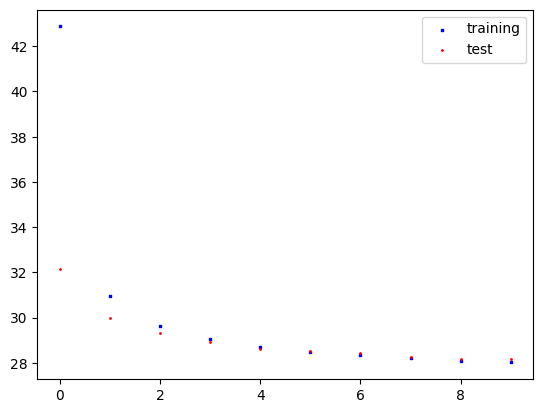

In [14]:
plt.figure()
plt.scatter(np.arange(df_losses.shape[0]), df_losses['training_loss'].values,
            color='blue', marker='s', s=1, label='training')
plt.scatter(np.arange(df_losses.shape[0]), df_losses['test_loss'].values,
            color='red', marker='o', s=1, label='test')
plt.legend(loc='best')
plt.show()

### 4. Evaluación del modelo

In [20]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
test_y_onehot = to_categorical(test_y, num_classes=10)  # 10 classes for MNIST

# Predict
xrec, _, _ = model.predict([test_x, test_y_onehot])

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


**Comparación entre imágenes originales y reconstruidas**

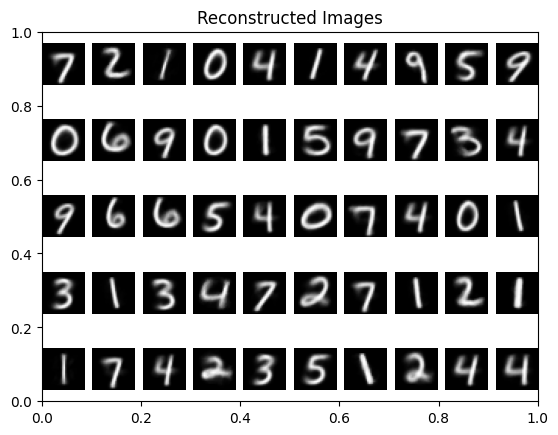

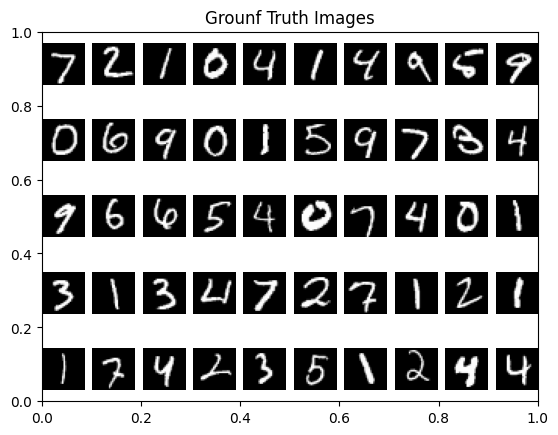

In [21]:
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(xrec[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(2)
plt.title('Grounf Truth Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(test_x[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

**Muestreo de nuevas imágenes con el decodificador**

In [22]:
decoder = tf.keras.Model(inputs = model.get_layer('z_vector').output, outputs = model.outputs[0], name='decoder')
decoder.trainable = False
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_37CLO… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_labels        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 12)        │          0 │ keras_tensor_37C… │
│ (Concatenate)       │                   │            │ input_labels[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        416 │ concatenate_2[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32)        │          0 │ dense_6[1][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      2,112 │ leaky_re_lu_6[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 64)        │          0 │ dense_7[1][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 1)   │          0 │ leaky_re_lu_7[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │      1,088 │ reshape_2[1][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │     65,600 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 16, 16,    │     65,600 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16384)     │          0 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 784)       │ 12,845,840 │ flatten_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 784)       │          0 │ dense_8[1][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 28, 28, 1) │          0 │ activation[1][0]  │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,980,656 (49.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,980,656 (49.52 MB)

In [28]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Generate random latent codes
noise_z = np.random.normal(size=[50, 2])

# Provide dummy inputs for the full model
dummy_img = np.zeros((50, 28, 28, 1))
dummy_labels = to_categorical(np.random.randint(0, 10, 50), num_classes=10)

# Test samples
sample_indices = np.random.choice(len(test_x), 50)
sample_x = test_x[sample_indices]
sample_y = to_categorical(test_y[sample_indices], num_classes=10)

# Reconstruct
xrec, _, _ = model.predict([sample_x, sample_y])
out_img = xrec

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


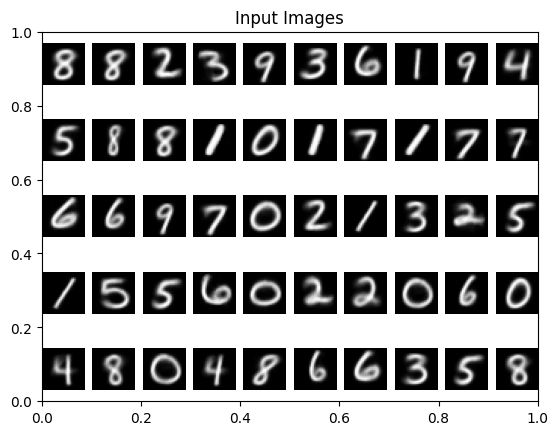

In [29]:
plt.figure(3)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(out_img[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()


In [30]:
encoder = tf.keras.Model(inputs = model.inputs, outputs = model.get_layer('z_vector').output, name='encoder')
encoder.trainable = False
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_labels        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7840)      │     86,240 │ input_labels[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 28, 28,    │          0 │ dense_3[0][0]     │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 11)               │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 13,    │     11,328 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 64)  │     65,600 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 64)  │     65,600 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │        130 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        130 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_vector (Lambda)   │ (None, 2)         │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,796 (897.64 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 229,796 (897.64 KB)

In [32]:
# One-hot encode labels
test_y_onehot = to_categorical(test_y, num_classes=10)  # 10 classes for MNIST

z = encoder.predict([test_x, test_y_onehot])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


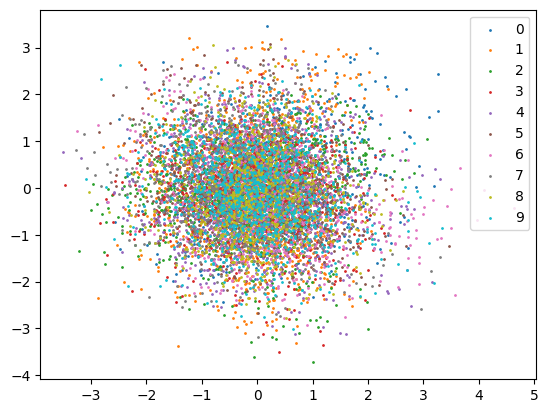

In [33]:
plt.figure()

for i in range(10):
    idx = np.argwhere(test_y == i)[:,0]
    plt.scatter(z[idx,0],z[idx,1],s=1, label=str(i))
plt.legend(loc='best')
plt.show()


## Visualización del espacio latente con T-SNE

Para entender cómo el VAE ha organizado la información en el espacio latente, aplicamos **T-SNE** (t-distributed Stochastic Neighbor Embedding), una técnica de reducción de dimensionalidad no lineal que permite proyectar representaciones de alta dimensión a dos dimensiones para su visualización.

Cada punto representa una imagen del conjunto de prueba, proyectada a partir de su representación latente. Los colores indican la etiqueta verdadera del dígito, lo que nos permite observar si el VAE ha aprendido una estructura significativa en el espacio latente.


In [34]:
from sklearn.manifold import TSNE

perplexity = 10
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
latent_tsne = tsne.fit_transform(z)

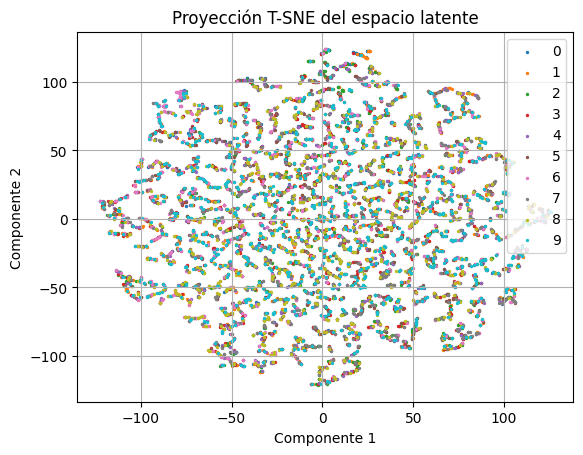

In [35]:
plt.figure()

for digit in range(10):

    idx = np.argwhere(test_y == digit)[:,0]
    plt.scatter(latent_tsne[idx, 0], latent_tsne[idx, 1], s=2, label=str(digit))

plt.title("Proyección T-SNE del espacio latente")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(loc='best')
plt.grid(True)
plt.show()
